# Data Challenge 2 - Reorder Sentences

Submitted by: Siqi Liu

Student ID: 20428295

WatIAm: sq2liu

## Set-Up

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/sentence-ordering')

In [3]:
!pip install transformers==4.2.2

In [4]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, RandomSampler, WeightedRandomSampler, SequentialSampler

In [5]:
from src import config
from src import data
from src import graph
from src import model
from src import utils

In [6]:
from importlib import reload

def reload_all():
  reload(config)
  reload(data)
  reload(graph)
  reload(model)
  reload(utils)

In [7]:
device = utils.get_device()

Current device: cuda


## Data

In [8]:
labeled_set = data.load_dataset(config.args['dir'] + config.args['labeled_filename'])
pred_set = data.load_dataset(config.args['dir'] + config.args['pred_filename'])

/content/drive/MyDrive/Colab Notebooks/sentence-ordering/data/train.pkl loaded. Size: 590226
/content/drive/MyDrive/Colab Notebooks/sentence-ordering/data/test.pkl loaded. Size: 2000


In [9]:
train_set, val_set = data.get_train_val_set(
    labeled_set,
    config.args['num_val_docs'],
    config.args['num_train_docs']
)

train_set size: 100000
val_set size: 500


In [10]:
tokenizer = model.load_tokenizer()

## First Sentence Model

### Create Datasets, Samplers and DataLoaders

In [11]:
train_dataset_fsent = data.FirstSentenceDataset(train_set, tokenizer, config.args['model_fsent']['max_length'])
val_dataset_fsent = data.FirstSentenceDataset(val_set, tokenizer, config.args['model_fsent']['max_length'])

Dataset loaded. Size: 600000
Dataset loaded. Size: 3000


In [12]:
train_weights_fsent, weight_one_fsent = data.get_weights_for_balanced_classes(
    train_dataset_fsent,
    target_ratio=config.args['model_fsent']['target_ratio']
)

train_sampler_fsent = WeightedRandomSampler(
    weights=train_weights_fsent,
    num_samples=config.args['model_fsent']['num_train_samples'],
    replacement=False
)

val_sampler_fsent = SequentialSampler(
    data_source=val_dataset_fsent
)

Weight for Ones: 5.0000


In [14]:
dataset_sizes_fsent = {
    'train' : config.args['model_fsent']['num_train_samples'],
    'val' : len(val_dataset_fsent),
}

print('train Dataset size: {:d}\nval Dataset size: {:d}'.format(
    dataset_sizes_fsent['train'], dataset_sizes_fsent['val']
))

train Dataset size: 10000
val Dataset size: 3000


In [15]:
train_dataloader_fsent = DataLoader(
    train_dataset_fsent,
    sampler=train_sampler_fsent,
    batch_size=config.args['model_fsent']['batch_size']
)

val_dataloader_fsent = DataLoader(
    val_dataset_fsent,
    sampler=val_sampler_fsent,
    batch_size=config.args['model_fsent']['batch_size']
)

In [16]:
dataloaders_fsent = {
    'train' : train_dataloader_fsent,
    'val' : val_dataloader_fsent
}

print('train DataLoader size: {:d}\nval DataLoader size: {:d}'.format(
    len(dataloaders_fsent['train']), len(dataloaders_fsent['val'])
))

train DataLoader size: 313
val DataLoader size: 94


### Load Pre-Trained Model

In [11]:
# model_fsent = model.load_model()

model_fsent = torch.load('{:s}fsent_model_checkpoint.pt'.format(
    config.args['dir'] + config.args['model_output_dir']
))

model_fsent.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Initialize Optimizer and Scheduler

In [17]:
optimizer_fsent = model.get_optimizer(
    model_fsent,
    config.args['model_fsent']['lr'],
    config.args['model_fsent']['adam_eps']
)

In [18]:
scheduler_fsent = model.get_scheduler(
    optimizer_fsent,
     config.args['model_fsent']['warmup_steps'],
    len(train_dataloader_fsent) * config.args['model_fsent']['num_epochs']
)

### Train Model

In [19]:
model_fsent, best_epoch_fsent, losses_fsent, accuracies_fsent = model.train_fsent(
    model=model_fsent,
    device=device,
    dataloaders=dataloaders_fsent,
    dataset_sizes=dataset_sizes_fsent,
    optimizer=optimizer_fsent,
    scheduler=scheduler_fsent,
    num_epochs=config.args['model_fsent']['num_epochs']
)

Epoch 1/3
----------


KeyboardInterrupt: ignored

### Plots

In [ ]:
utils.plot_statistics("Loss", losses_fsent)

In [ ]:
utils.plot_statistics("Accuracy", accuracies_fsent)

## Pairwise Model

### Create Training Dataset, Sampler and DataLoader

In [21]:
train_dataset_pair = data.SentencePairDataset(train_set, tokenizer, config.args['model_pair']['max_length'])

Dataset loaded. Size: 1500000


In [22]:
# should be around 0.5
np.mean(train_dataset_pair.labels)

0.500198

In [23]:
train_sampler_pair = RandomSampler(
    data_source=train_dataset_pair,
    num_samples=config.args['model_pair']['num_train_samples'],
    replacement=True
)

In [24]:
train_dataloader_pair = DataLoader(
    train_dataset_pair,
    sampler=train_sampler_pair,
    batch_size=config.args['model_pair']['batch_size']
)

### Load Pre-Trained Model

In [25]:
model_pair = model.load_model()

# model_pair = torch.load('{:s}pair_model_checkpoint.pt'.format(
#     config.args['dir'] + config.args['model_output_dir']
# ))

model_pair.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Initialize Optimizer and Scheduler

In [26]:
optimizer_pair = model.get_optimizer(
    model_pair,
    config.args['model_pair']['lr'],
    config.args['model_pair']['adam_eps']
)

In [27]:
scheduler_pair = model.get_scheduler(
    optimizer_pair,
    config.args['model_pair']['warmup_steps'],
    len(train_dataloader_pair) * config.args['model_pair']['num_epochs']
)

### Train Model

In [28]:
model_pair, best_epoch_pair, losses_pair, accuracies_pair, spearmans_pair = model.train_pair(
    model=model_pair,
    model_fsent=model_fsent,
    tokenizer=tokenizer,
    device=device,
    val_set=val_set,
    train_dataloader=train_dataloader_pair,
    optimizer=optimizer_pair,
    scheduler=scheduler_pair,
    num_epochs=config.args['model_pair']['num_epochs']
)

Epoch 1/20
----------



train Loss: 0.5273; Acc: 0.7066



Best model so far! Saved checkpoint.

Epoch 2/20
----------



train Loss: 0.4316; Acc: 0.7851




Epoch 3/20
----------



train Loss: 0.4247; Acc: 0.7851



Best model so far! Saved checkpoint.

Epoch 4/20
----------



train Loss: 0.4234; Acc: 0.7865




Epoch 5/20
----------



train Loss: 0.4012; Acc: 0.7996




Epoch 6/20
----------



train Loss: 0.3944; Acc: 0.8055



Best model so far! Saved checkpoint.

Epoch 7/20
----------



train Loss: 0.3805; Acc: 0.8156




Epoch 8/20
----------



train Loss: 0.3836; Acc: 0.8085




Epoch 9/20
----------



train Loss: 0.3746; Acc: 0.8173




Epoch 10/20
----------



train Loss: 0.3688; Acc: 0.8192




Epoch 11/20
----------



train Loss: 0.3535; Acc: 0.8254




Epoch 12/20
----------



train Loss: 0.3536; Acc: 0.8290




Epoch 13/20
----------



train Loss: 0.3453; Acc: 0.8355




Epoch 14/20
----------



train Loss: 0.3381; Acc: 0.8318



Best model so far! Saved checkpoint.

Epoch 15/20
----------



train Loss: 0.3399; Acc: 0.8368



Best model so far! Saved checkpoint.

Epoch 16/20
----------



train Loss: 0.3353; Acc: 0.8355




Epoch 17/20
----------



train Loss: 0.3304; Acc: 0.8411




Epoch 18/20
----------



train Loss: 0.3314; Acc: 0.8400




Epoch 19/20
----------



train Loss: 0.3224; Acc: 0.8460




Epoch 20/20
----------



train Loss: 0.3282; Acc: 0.8410




Training complete in 238m 1s
Best Val Spearman: 0.717486 at Epoch: 14


### Plots

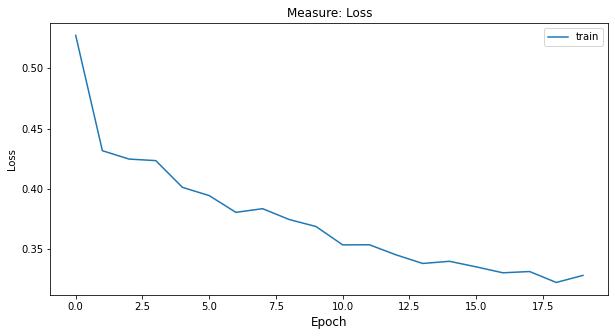

In [29]:
utils.plot_statistics("Loss", losses_pair)

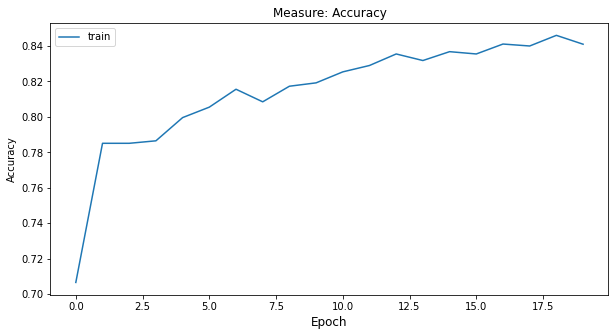

In [30]:
utils.plot_statistics("Accuracy", accuracies_pair)

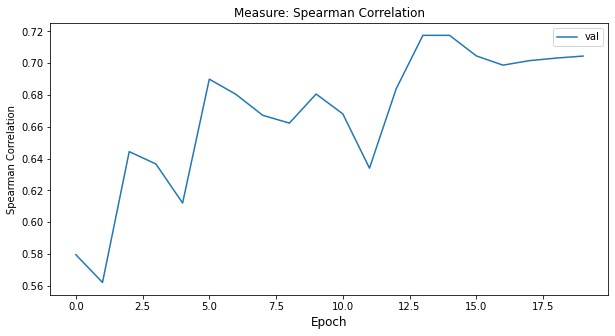

In [31]:
utils.plot_statistics("Spearman Correlation", spearmans_pair)

## Example

In [32]:
doc = val_set[207]

doc

{'ID': 375723,
 'indexes': [5, 0, 4, 1, 2, 3],
 'sentences': ['Laurel Hollow is a village located on the North Shore of Long Island.',
  'Harvinder "Harry" Anand is the former Mayor of Laurel Hollow, New York; he was elected on June 19, 2007.',
  'He did not run for a fourth term in 2013.',
  'He is the first elected Indian-American mayor in the state of New York.',
  'He was sworn into office on July 2, 2007.',
  'In June 2011, he was reelected to his third term as mayor.']}

In [17]:
# predict first sentence position
fsent_pos = model.predict_fsent_pos(doc, device, model_fsent, tokenizer)

fsent_pos

0

In [18]:
# predict sentence pairs logits
pair_logits = model.predict_pair_logits(doc, device, model_pair, tokenizer)

pair_logits

[(0, 1, array([-0.12380011, -0.09012955], dtype=float32)),
 (0, 2, array([0.13207927, 0.41750377], dtype=float32)),
 (0, 3, array([0.31128934, 0.53761685], dtype=float32)),
 (0, 4, array([0.13409792, 0.40604442], dtype=float32)),
 (0, 5, array([0.14776887, 0.49956092], dtype=float32)),
 (1, 2, array([0.00354131, 0.24333596], dtype=float32)),
 (1, 3, array([-0.10980047, -0.40202677], dtype=float32)),
 (1, 4, array([-0.09239233, -0.3694715 ], dtype=float32)),
 (1, 5, array([-0.11210063, -0.22227395], dtype=float32)),
 (2, 3, array([0.12833811, 0.38248777], dtype=float32)),
 (2, 4, array([0.17157052, 0.3682689 ], dtype=float32)),
 (2, 5, array([0.05572493, 0.20418024], dtype=float32)),
 (3, 4, array([-0.01362008,  0.15223244], dtype=float32)),
 (3, 5, array([-0.09260076, -0.16027454], dtype=float32)),
 (4, 5, array([-0.07859644,  0.00314521], dtype=float32))]

In [ ]:
# construct graph based on predictions
num_vertices = len(doc['sentences'])
g = model.make_graph(num_vertices, pair_logits)

g.graph

In [ ]:
# sort and get the order
if config.args['graph_method'] == 'max_flow':
    order, weight = g.max_flow(fsent_pos)
elif config.args['graph_method'] == 'greedy':
    order, weight = g.greedy(fsent_pos)
else:
    raise InvalidInputError()

order, weight

In [ ]:
indexes = [-1] * num_vertices
for p, o in enumerate(order):
    indexes[o] = p

indexes

## Confirm Validation Set Score

In [13]:
mean_val_spearman, worst_spearman_docs = model.evaluate(val_set, device, model_fsent, model_pair, tokenizer)

mean_val_spearman

0.36902857142857093

In [14]:
worst_spearman_docs

[{'ID': 375723,
  'indexes': [5, 0, 4, 1, 2, 3],
  'sentences': ['Laurel Hollow is a village located on the North Shore of Long Island.',
   'Harvinder "Harry" Anand is the former Mayor of Laurel Hollow, New York; he was elected on June 19, 2007.',
   'He did not run for a fourth term in 2013.',
   'He is the first elected Indian-American mayor in the state of New York.',
   'He was sworn into office on July 2, 2007.',
   'In June 2011, he was reelected to his third term as mayor.']}]

In [15]:
for i, d in enumerate(val_set):
    if d['ID'] == 375723:
        print(i)

207


## Submission

In [33]:
submission = model.predict_submission(pred_set, device, model_fsent, model_pair, tokenizer)

submission

,ID,index1,index2,index3,index4,index5,index6
0,1,1,3,4,2,5,0
1,2,3,1,5,0,2,4
2,3,1,2,3,0,4,5
3,4,2,0,3,1,5,4
4,5,3,2,5,0,1,4
...,...,...,...,...,...,...,...
1995,1996,0,5,2,4,1,3
1996,1997,1,2,3,4,0,5
1997,1998,1,5,4,2,3,0
1998,1999,3,1,2,4,5,0


In [34]:
submission.to_csv(config.args['dir'] + 'submission.csv', index=False)